In [139]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
# import optuna

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


import random
from PIL import Image
import cv2

In [140]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [141]:
%cd /home/spyros/Desktop/DNN/
data = pd.read_csv('data_enum.csv')
data

/home/spyros/Desktop/DNN


,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path
0,HAM_0001751,ISIC_0024698,1,consensus,70,male,face,False,HAM10000_images_part_1/nv/ISIC_0024698.jpg
1,HAM_0000559,ISIC_0024693,1,follow_up,45,female,upper extremity,False,HAM10000_images_part_1/nv/ISIC_0024693.jpg
2,HAM_0004932,ISIC_0032212,1,follow_up,45,female,foot,False,HAM10000_images_part_2/nv/ISIC_0032212.jpg
3,HAM_0004516,ISIC_0025775,1,follow_up,45,female,neck,False,HAM10000_images_part_1/nv/ISIC_0025775.jpg
4,HAM_0006510,ISIC_0029828,1,follow_up,55,female,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0029828.jpg
...,...,...,...,...,...,...,...,...,...
30900,HAM_0000982,ISIC_0032356,6,histo,60,male,lower extremity,False,HAM10000_images_part_2/akiec/ISIC_0032356.jpg
30901,HAM_0006746,ISIC_0026872,6,histo,85,male,lower extremity,False,HAM10000_images_part_1/akiec/ISIC_0026872.jpg
30902,HAM_0004033,ISIC_0027452,6,histo,70,male,upper extremity,False,HAM10000_images_part_1/akiec/ISIC_0027452.jpg
30903,HAM_0002472,ISIC_0025696,6,histo,60,male,face,False,HAM10000_images_part_1/akiec/ISIC_0025696.jpg


In [154]:
# colored_array = data.iloc[0]['image_path']
# img = Image.open(colored_array)
# img.size


(600, 450)

# Convert the Data to Tensors

In [106]:
def compute_img_mean_std(image_paths):
    img_h, img_w = 224, 224
    n_pixels = 0
    sum_channels = np.zeros(3)
    sum_squares_channels = np.zeros(3)

    for path in tqdm(image_paths):
        img = cv2.imread(path)
        img = cv2.resize(img, (img_w, img_h))
        img = img.astype(np.float32) / 255.

        sum_channels += img.sum(axis=(0, 1))
        sum_squares_channels += (img ** 2).sum(axis=(0, 1))
        n_pixels += img_h * img_w

    mean_channels = sum_channels / n_pixels
    std_channels = np.sqrt(sum_squares_channels / n_pixels - mean_channels ** 2)

    # Convert from BGR to RGB
    mean_channels = mean_channels[::-1].tolist() #error rises when they are arrays
    std_channels = std_channels[::-1].tolist()
    print(f"normMean = {mean_channels}")
    print(f"normStd = {std_channels}")

    return mean_channels, std_channels

In [107]:
norm_means, norm_std = compute_img_mean_std(data['image_path'])

100%|██████████| 30905/30905 [03:08<00:00, 164.07it/s]

normMean = [0.77184154 0.55760952 0.58333543]
normStd = [0.12637522 0.14236803 0.15175888]


**Data rotation, cutting and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [119]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((224,224)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                    transforms.Normalize(norm_means, norm_std)])

In [126]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx',img_col='image_path', transform=None):
        self.data = data
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform or transforms.ToTensor()  # Normalize the pixels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx][self.img_col]
        image = Image.open(image_path)

        label = torch.tensor(self.data.iloc[idx][self.label_column])

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        return image, label

In [127]:
data = data.sample(frac=1) 

train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=train_transform)
val_dataset = HAM10000Dataset(val_data, transform=val_transform)
test_dataset = HAM10000Dataset(test_data, transform=val_transform)

In [128]:
batch_size = 108
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print('Data Len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data Len Train: 18543 Val: 6181 Test: 6181


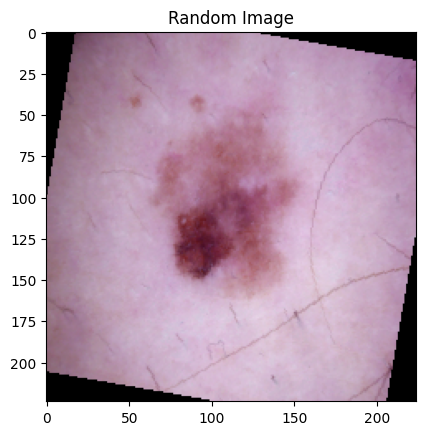

In [137]:
rand = random.randint(0, train_data.shape[0])

sample_image_path = train_data.iloc[rand]['image_path']
sample_image = Image.open(sample_image_path)

random_img = train_transform(sample_image)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(norm_means)
    std = np.array(norm_std)
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


imshow(random_img, title='Random Image')

# Make the custom model

In [138]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Padding to keep dimensions
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Pooling layer - using Average Pooling
        self.pool = nn.AvgPool2d(2, 2)
        
        # Fully connected layers
        # Size calculation depends on the input image size and conv/pool layers
        self.fc1 = nn.Linear(128 * image_size_after_convs, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)  # num_classes is the number of your output classes

    def forward(self, x):
        # Apply convolutions and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Apply fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
# Replace `image_size_after_convs` with the calculated size and `num_classes` with the actual number of classes
cnnet = CNNet()
